#  Positioning currently running vehicles

In [38]:
from collections import defaultdict
import json, requests
import pprint
import math
#from collections import namedtuple
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
import pickle

%matplotlib inline

# Loading pickled data

In [39]:
#Open data file with pickled data in read mode (binary format)
static_LAmetro_data_fileobj = open('static_LAmetro_data', 'rb') 

#Get pickled data
static_data = pickle.load(static_LAmetro_data_fileobj)


print(static_data.keys())

dict_keys(['routes', 'stops', 'stop_coordinates_and_distances', 'current_vehicles', 'route_wise_current_vehicles'])


In [40]:
routes = static_data['routes']
stops = static_data['stops']
stop_coordinates_and_distances = static_data['stop_coordinates_and_distances']
current_vehicles = static_data['current_vehicles']
route_wise_current_vehicles = static_data['route_wise_current_vehicles']

# Reference map plot of the LAMetro-rail routes

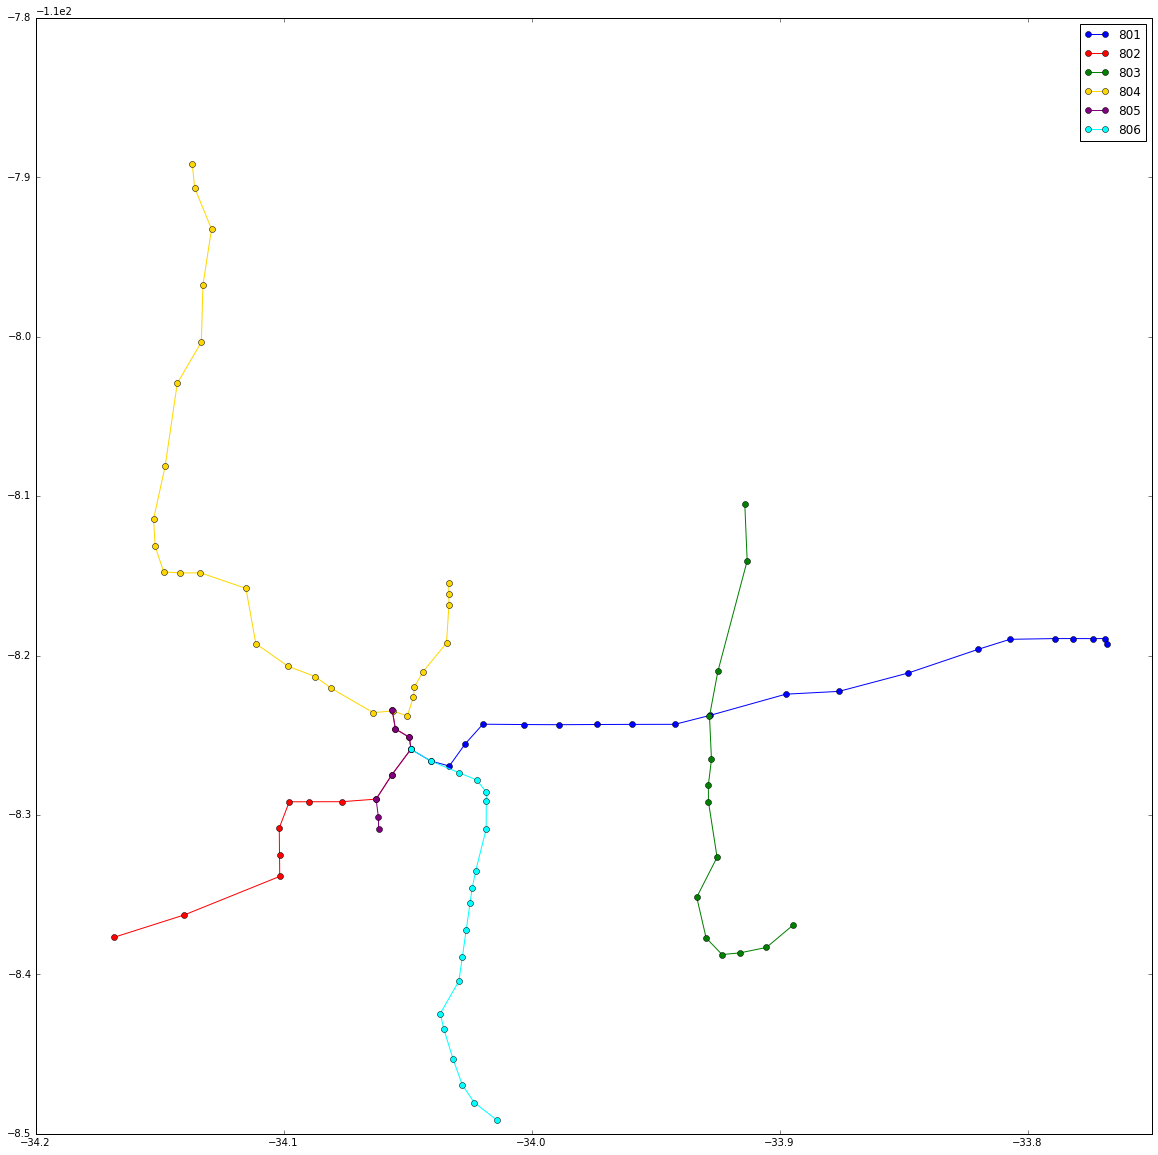

In [41]:
lametro_map =plt.figure(figsize=(20,20))
for route in stops:
    current_color = routes[route]['color']
    latitudes = []
    longitudes = []
    for stop in stops[route]:
        #Horizontal flip to align with the other map
        latitudes.append(-1*stop['latitude'])
        longitudes.append(stop['longitude'])
    plt.plot(latitudes,longitudes, color=current_color, linestyle="solid", marker="o", label=route)
plt.legend();


# Finding nearest stations of current vehicles

## Method 1: Bounding by Rectangular boxes

In [42]:
def scale(n, input_list):
    output_list = []
    for item in input_list:
        output_list.append(list(map(lambda x: n*x,item)))
        
    return output_list
    
def draw_bounding_boxes(route):

    stops_coordinates = stop_coordinates_and_distances[route]['stop_coordinates']
    stops_latitudes = [coordinates[0] for coordinates in stops_coordinates]
    stops_longitudes = [coordinates[1] for coordinates in stops_coordinates]
    widths_between_stops = stop_coordinates_and_distances[route]['widths_between_stops']
    heights_between_stops = stop_coordinates_and_distances[route]['heights_between_stops']
    
    current_vehicles_latitudes = route_wise_current_vehicles[route]['latitudes']
    current_vehicles_longitudes = route_wise_current_vehicles[route]['longitudes']
    current_no_of_vehicles = route_wise_current_vehicles[route]['no_of_vehicles']
    
    
#     s = [stops_coordinates,stops_latitudes,stops_longitudes,widths_between_stops,heights_between_stops]
#     c = [current_vehicles_latitudes,current_vehicles_longitudes]
#     s = scale(10000,s)
#     c = scale(10000,c)
#     stops_coordinates,stops_latitudes,stops_longitudes,widths_between_stops,heights_between_stops= s
#     current_vehicles_latitudes,current_vehicles_longitudes = c
    
    
    
    current_color = routes[route]['color']

    current_route_map, ax =plt.subplots(1)
    plt.plot(stops_latitudes,stops_longitudes, 
             color=current_color, linestyle="solid", marker=".", label=route)
    for latitude, longitude, width, height in zip(stops_latitudes[:-1], stops_longitudes[:-1],widths_between_stops,heights_between_stops):
        #plt.axvline(latitude, linestyle='--')
        #plt.axhline(longitude, linestyle=':')
        rectangle = mpl.patches.Rectangle((latitude,longitude), width,height, facecolor=current_color)
        ax.add_patch(rectangle)
        
    plt.scatter(current_vehicles_latitudes, current_vehicles_longitudes, color ="black", marker ="^", s=70)
    
    plt.legend();
    
        



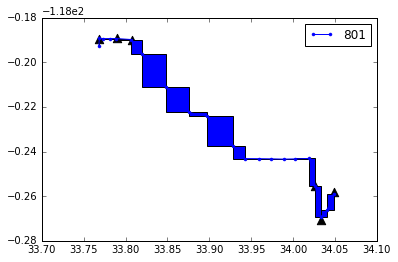

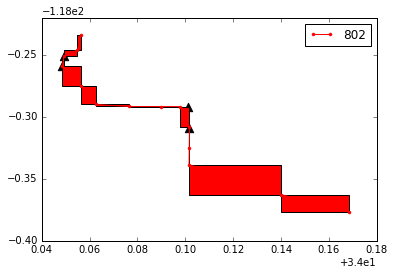

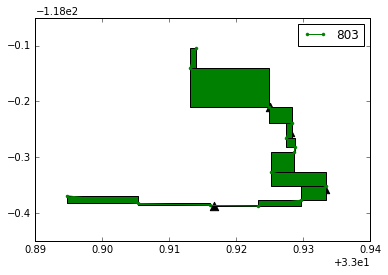

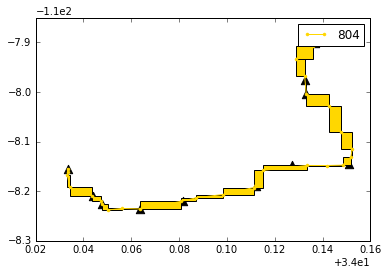

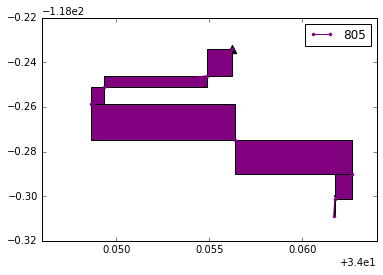

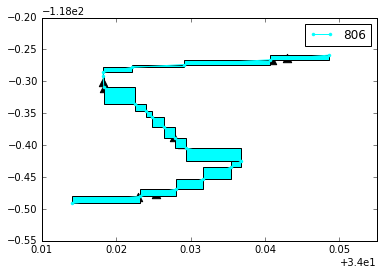

In [43]:
for route in routes:
    draw_bounding_boxes(route)

## Method 2: Orthogonal projection to linesegments joining adjacent stations

In [44]:
def orthogonal_projection(point, start_station, end_station, dist_bet_stations):
    point = np.array(list(point))
    start_station = np.array(list(start_station))
    end_station = np.array(list(end_station))
    #Translate by -start_station
    new_start = start_station-start_station
    new_end = end_station-start_station
    new_point = point-start_station
    #print(f"Distances match : {np.linalg.norm(new_end-new_start)==dist_bet_stations}")
    unit_vector_along_stations = (new_end-new_start)/dist_bet_stations
    signed_length_of_projection = (np.dot(new_point, new_end).item())/dist_bet_stations
    in_opp_direction = (signed_length_of_projection < 0)
    is_in_between = False
    if not in_opp_direction:
        is_in_between = (signed_length_of_projection<dist_bet_stations)        
    new_projection_point = signed_length_of_projection*unit_vector_along_stations
    projection_point = new_projection_point + start_station
    projection_point = (projection_point[0].item(),projection_point[1].item())
    orthogonal_distance = np.linalg.norm(new_point - new_projection_point)
    return orthogonal_distance, projection_point, signed_length_of_projection, is_in_between
    
    
    

In [45]:
def plot_adj_stations(point, projection_point, start, end, title, equal_aspect=False):
    fig, ax =plt.subplots(figsize=(7,7))
    plt.plot([point[0], projection_point[0]], [point[1], projection_point[1]], color ="black", label="orthogonal projection")
    plt.plot([start[0], end[0],projection_point[0]], [start[1], end[1], projection_point[1]], color="blue", linestyle="--", label="extension")
    plt.plot([start[0], end[0]], [start[1], end[1]], color="red", marker=".", linestyle="solid", label="stations")
    plt.scatter([point[0]], [point[1]], color ="black", marker = "^", label="current_vehicle")
    plt.scatter([start[0]], [start[1]], color ="red", marker = "^", label="start")
    plt.scatter([projection_point[0]], [projection_point[1]], color ="green", marker ="*" , label="projection point")
    if equal_aspect:
        ax. set_aspect('equal')
    ax.set_title(title)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False)

    #ax.legend(bbox_to_anchor=(2, 1));

Route is 801

orthogonal_distance, projection_point, signed_length_of_projection, is_in_between 
 =  (0.21432353217658728, (33.95315791145944, -118.34724633456169), 0.13011648150931066, False)

Route is 803

orthogonal_distance, projection_point, signed_length_of_projection, is_in_between 
 =  (0.038182693754957066, (33.902971413145885, -118.38007160861719), 0.013696933424135933, True)



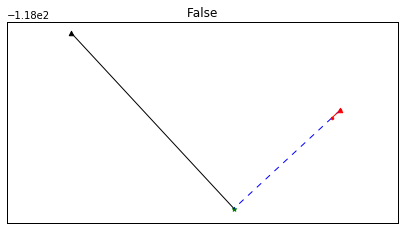

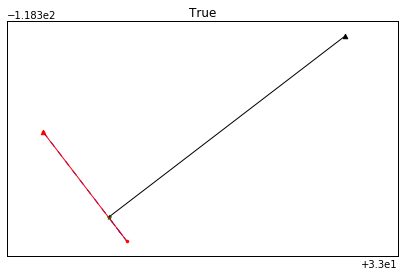

In [46]:
#Testing if orthogonal projection works for one instance
in_between = 0
not_in_between = 0
for route in stop_coordinates_and_distances:
    if in_between >=1 and not_in_between >=1:
            break
    stop_coordinates = stop_coordinates_and_distances[route]['stop_coordinates']
    stop_distances = stop_coordinates_and_distances[route]['stop_distances']
    vehicle_coordinates = route_wise_current_vehicles[route]['vehicle_coordinates']
    start = stop_coordinates[0]
    end = stop_coordinates[1]
    for i in range(route_wise_current_vehicles[route]['no_of_vehicles']):
        point = vehicle_coordinates[i]
        distance = stop_distances[0]
#         print(f"start {start}")
#         print(f"end {end}")
#         print(f"point {point}")
#         print(f"distance {distance}")
#         print()
        output = orthogonal_projection(point, start, end, distance)
        projection_point = output[1]

        if output[3]:  
            in_between +=1
        else:
            not_in_between +=1
        if (output[3] and in_between <=1) or ((not output[3]) and not_in_between <=1):
            print(f"Route is {route}")
            print()
            print(f"orthogonal_distance, projection_point, signed_length_of_projection, is_in_between \n =  {output}")
            print()
            plot_adj_stations(point, projection_point, start, end, output[3], True)

        if in_between >=1 and not_in_between >=1:
            break
            
    

In [47]:
def find_adjacent_stations(vehicle_coordinate, stop_coordinates, stop_distances, no_of_stops):
    orthogonal_projection_details = [] 
    for pos in range(no_of_stops-1):
        start_station = stop_coordinates[pos]
        end_station = stop_coordinates[pos+1]
        dist_bet_stations = stop_distances[pos]
        point = vehicle_coordinate
        orthogonal_projection_details.append((pos, *orthogonal_projection(point, 
                                                                   start_station,
                                                                   end_station, dist_bet_stations)))
    in_between_vehicles = [x for x in orthogonal_projection_details if x[4]]
    if in_between_vehicles:
        min_in_between = min(in_between_vehicles, key=lambda x:x[1])
    else:
        min_in_between = None
    not_in_between_vehicles = [x for x in orthogonal_projection_details if not x[4]]
    if not_in_between_vehicles:
        min_not_in_between = min(not_in_between_vehicles, key=lambda x:x[1])
    else:
        min_not_in_between = None
    
    return min_in_between, min_not_in_between
    
    

In [48]:
def plot_stations(point, projection_points, starts, ends, title, in_betweens):
    fig, ax =plt.subplots(figsize=(7,7))
    for start, end, projection_point, in_between in zip(starts, ends, projection_points, in_betweens):
        mycolor = "black" if in_between else "yellow"
        plt.plot([point[0], projection_point[0]], [point[1], projection_point[1]], color = mycolor, label="orthogonal projection")
        plt.plot([start[0], end[0],projection_point[0]], [start[1], end[1], projection_point[1]], color="blue", linestyle="--", label="extension")
        plt.plot([start[0], end[0]], [start[1], end[1]], color="red", marker=".", linestyle="solid", label="stations")
        plt.scatter([point[0]], [point[1]], color ="black", marker = "^", label="current_vehicle")
        plt.scatter([start[0]], [start[1]], color ="red", marker = "^", label="start")
        plt.scatter([projection_point[0]], [projection_point[1]], color ="green", marker ="*" , label="projection point", s=20)
    #ax.set_aspect('equal')
    ax.set_title(title)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False)

    #ax.legend(bbox_to_anchor=(2, 1));

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


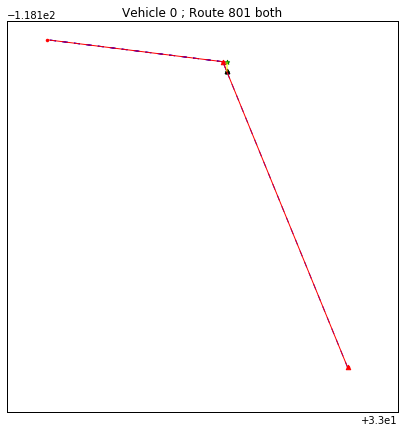

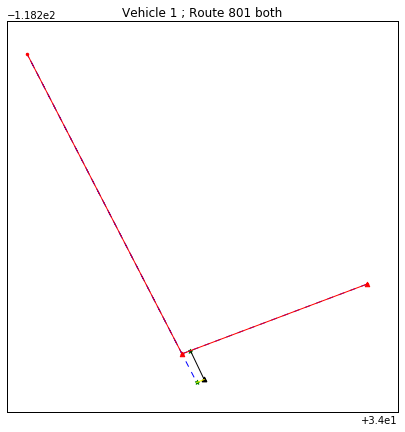

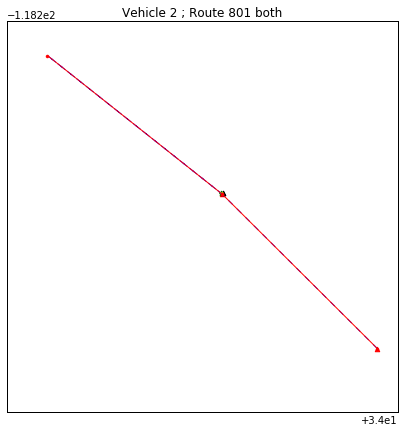

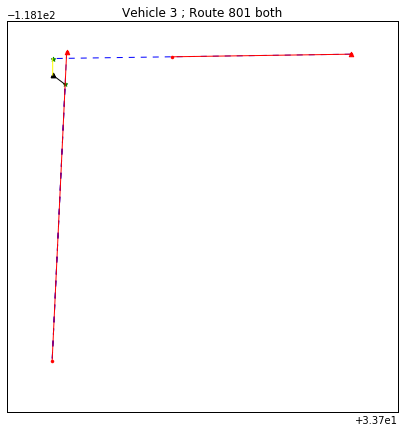

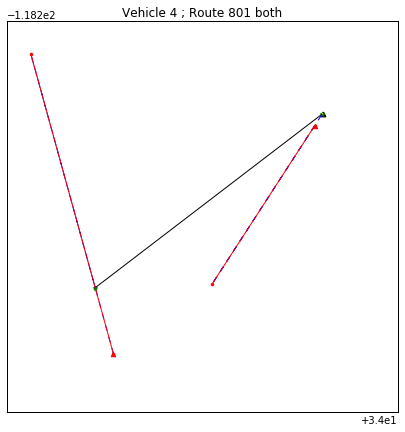

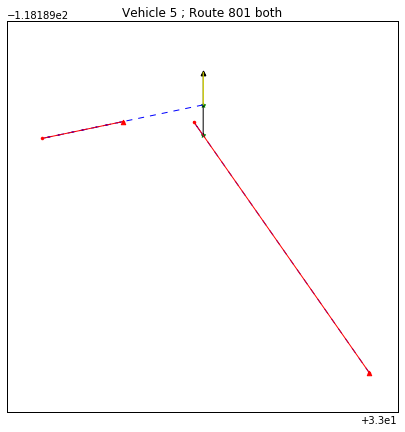

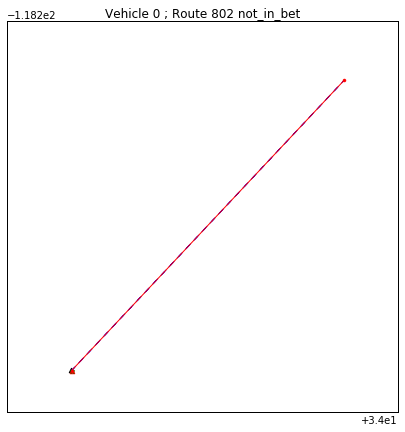

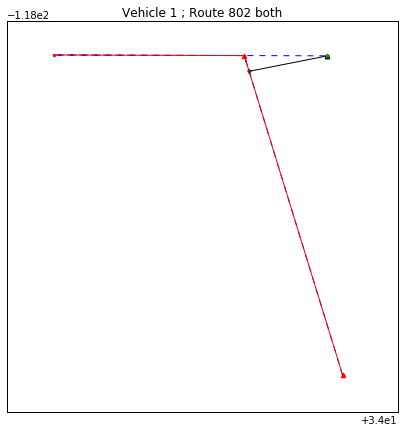

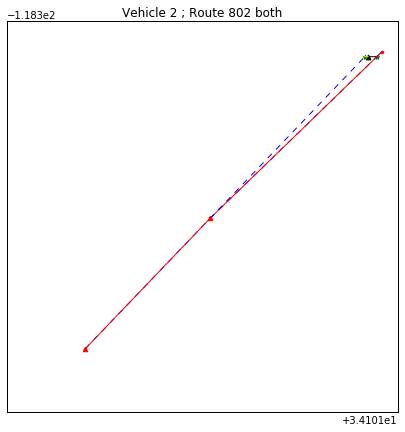

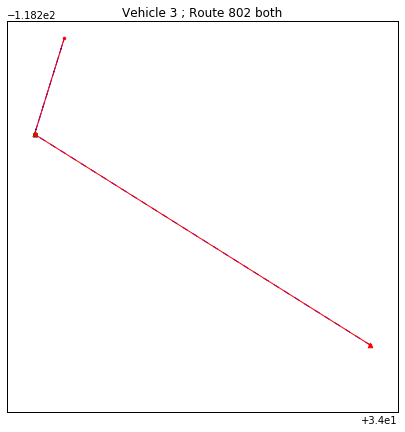

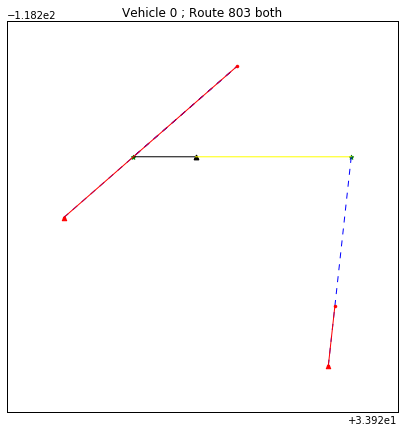

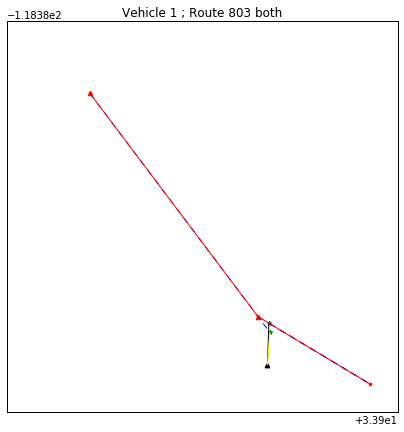

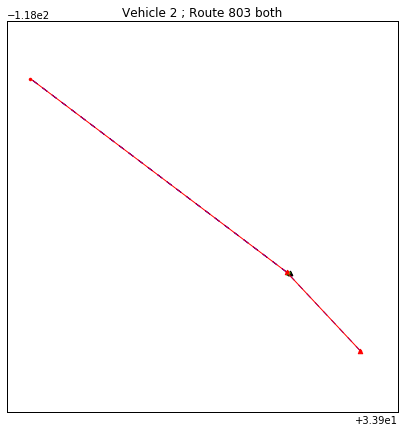

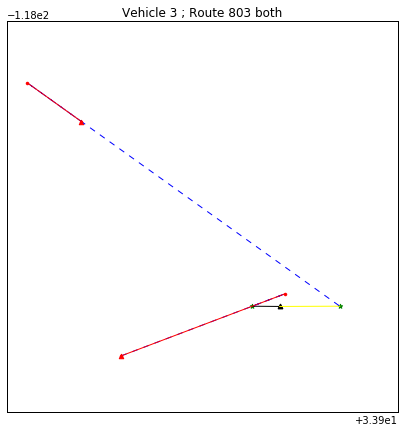

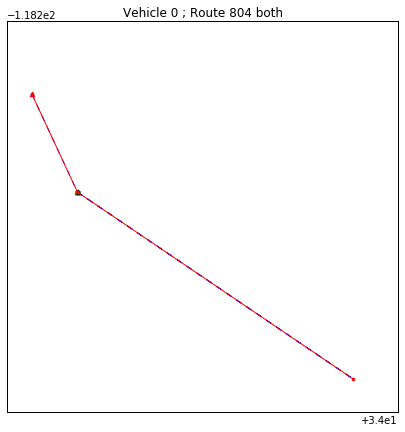

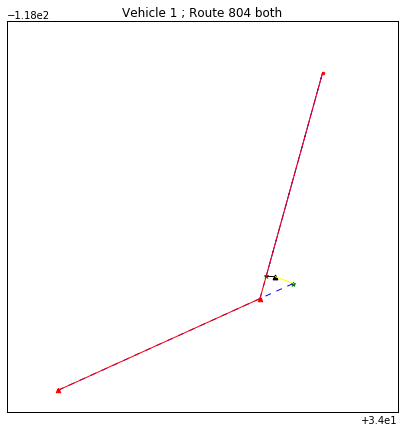

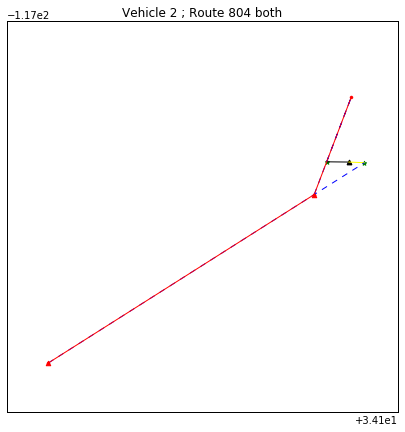

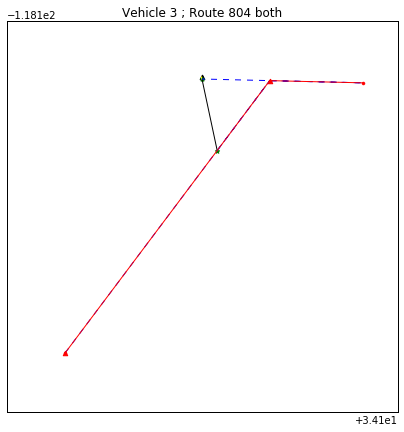

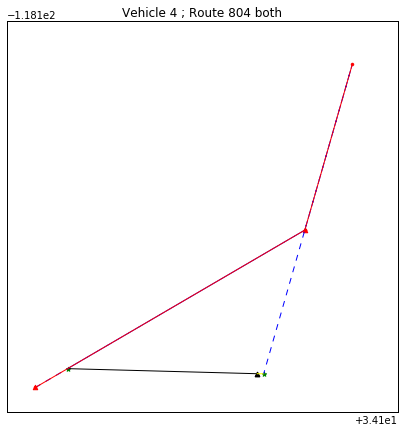

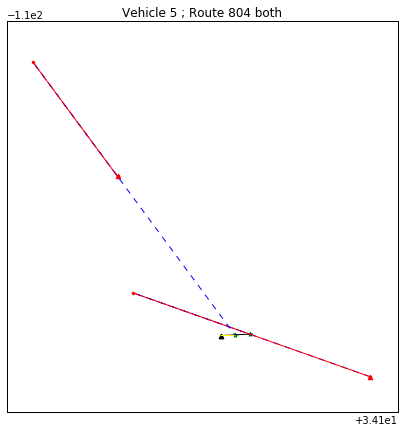

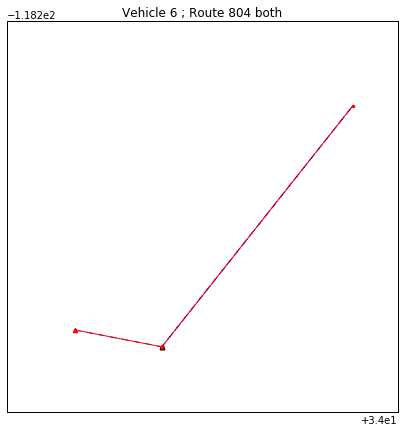

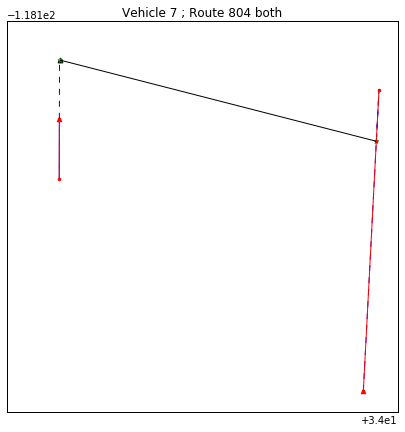

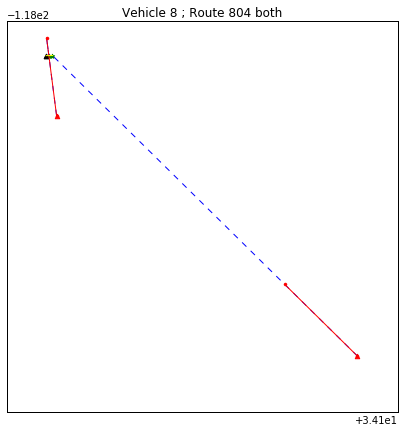

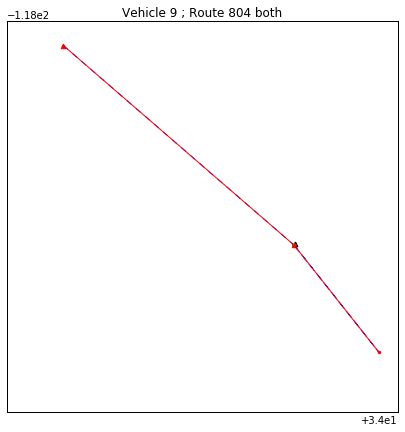

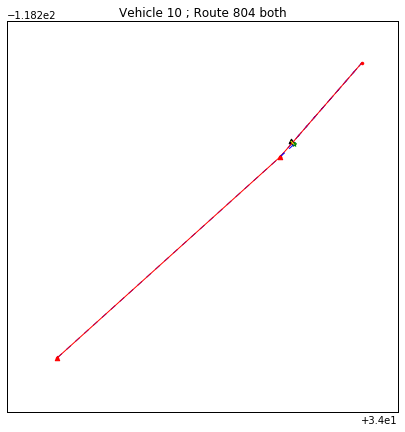

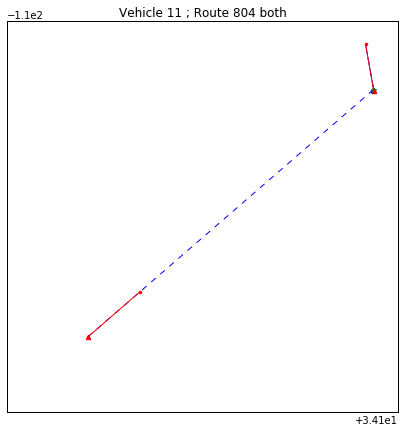

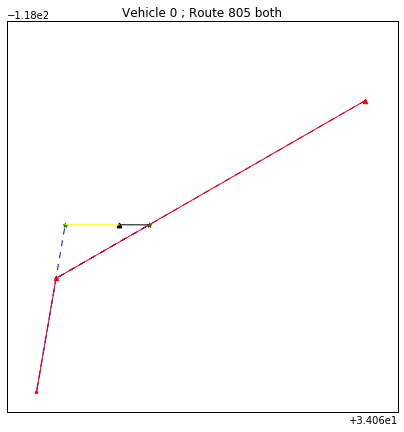

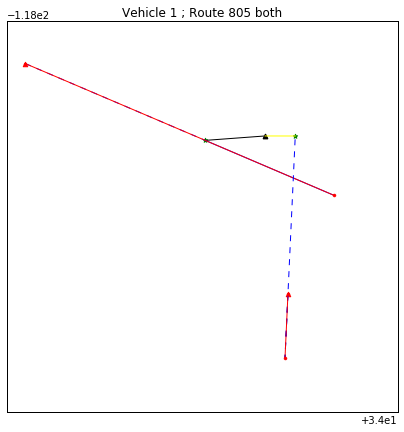

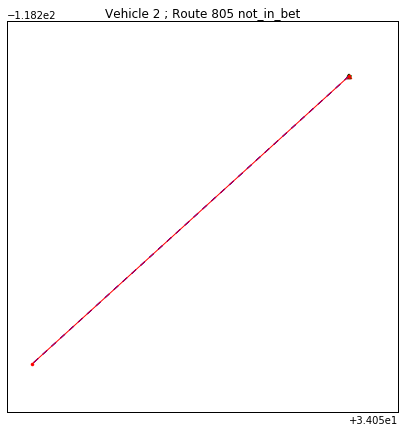

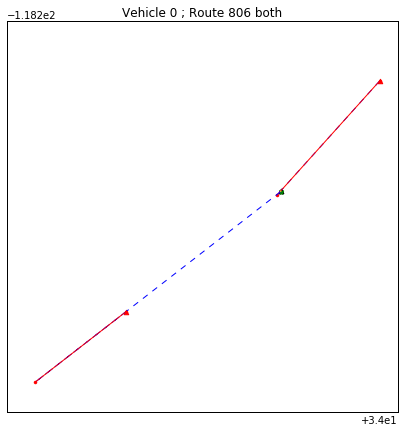

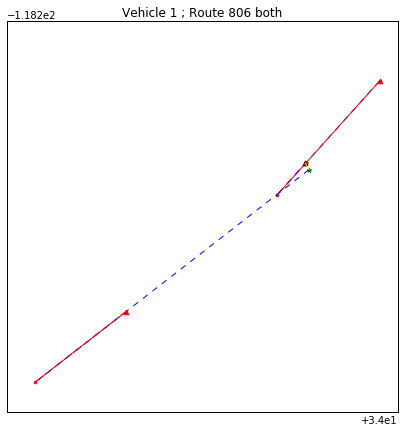

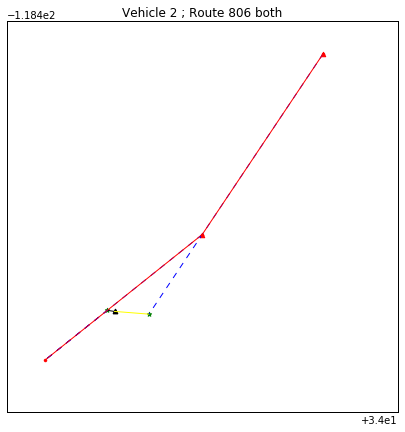

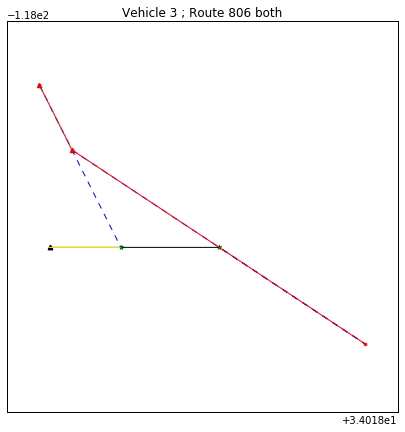

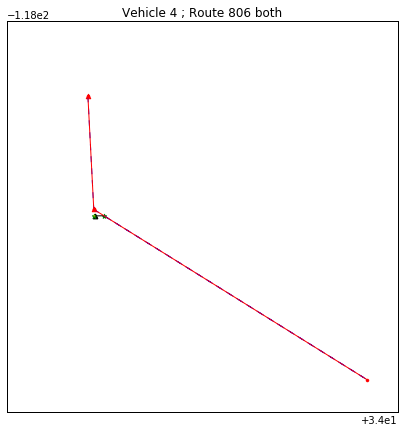

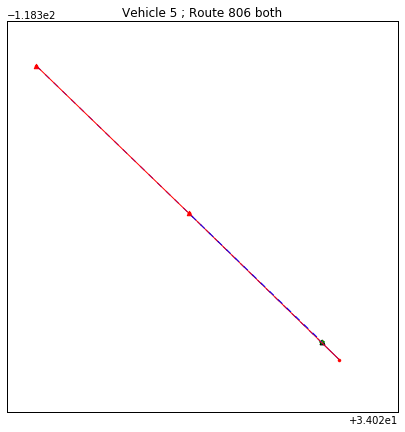

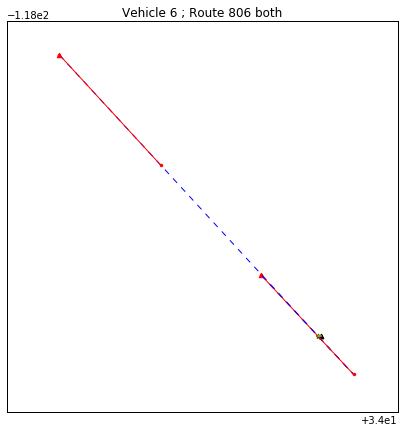

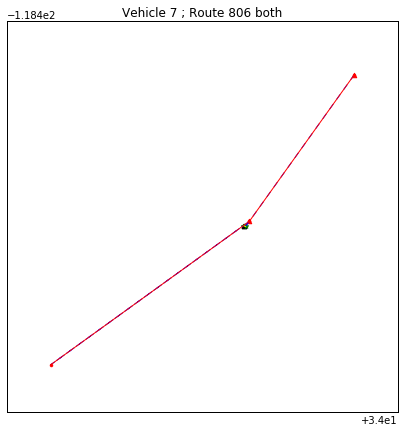

In [49]:
for route in stop_coordinates_and_distances:
    no_of_stops = stop_coordinates_and_distances[route]['no_of_stops']
    stop_coordinates = stop_coordinates_and_distances[route]['stop_coordinates']
    stop_distances = stop_coordinates_and_distances[route]['stop_distances']
    vehicle_coordinates = route_wise_current_vehicles[route]['vehicle_coordinates']
    distance = stop_distances
    for pos, vehicle_coordinate in enumerate(vehicle_coordinates):
        output_in_between, output_not_in_between = find_adjacent_stations(vehicle_coordinate, stop_coordinates, stop_distances, no_of_stops)
        #pprint.pprint(output_in_between)
        #print()
        #pprint.pprint(output_not_in_between)
        #print("******************")
        title = f"Vehicle {pos} ; Route {route}"
        if output_in_between and output_not_in_between: 
            title += " both"
            output = list(zip(output_in_between, output_not_in_between))
            starts = []
            ends = []
            for i in output[0]:
                starts.append(stop_coordinates[i])
                ends.append(stop_coordinates[i+1])
            plot_stations(vehicle_coordinate, output[2], starts, ends, title, output[-1])
        elif output_in_between is not None:
            title += " in_bet"
            plot_adj_stations(vehicle_coordinate, output_in_between[2], stop_coordinates[output_in_between[0]],
                              stop_coordinates[output_in_between[0]+1], title)
        elif output_not_in_between is not None:
            title += " not_in_bet"
            plot_adj_stations(vehicle_coordinate, output_not_in_between[2], stop_coordinates[output_not_in_between[0]],
                              stop_coordinates[output_not_in_between[0]+1], title)
        
  

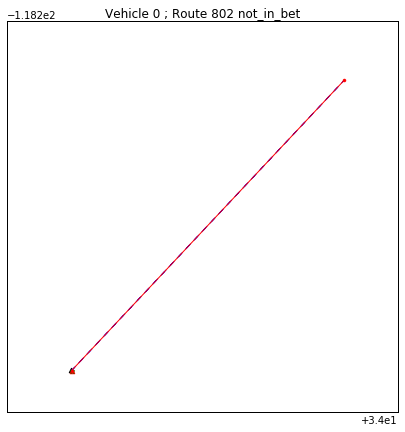

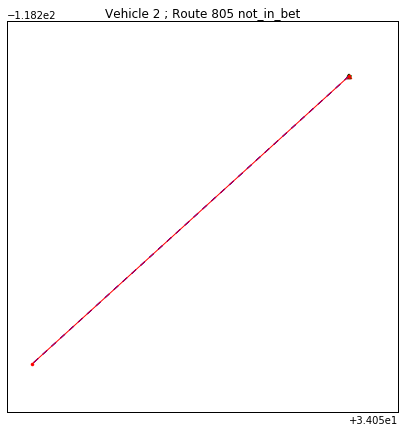

In [50]:
#Analyzing only not-in-betweens
for route in stop_coordinates_and_distances:
    no_of_stops = stop_coordinates_and_distances[route]['no_of_stops']
    stop_coordinates = stop_coordinates_and_distances[route]['stop_coordinates']
    stop_distances = stop_coordinates_and_distances[route]['stop_distances']
    vehicle_coordinates = route_wise_current_vehicles[route]['vehicle_coordinates']
    distance = stop_distances
    for pos, vehicle_coordinate in enumerate(vehicle_coordinates):
        output_in_between, output_not_in_between = find_adjacent_stations(vehicle_coordinate, stop_coordinates, stop_distances, no_of_stops)
        #pprint.pprint(output_in_between)
        #print()
        #pprint.pprint(output_not_in_between)
        #print("******************")
        title = f"Vehicle {pos} ; Route {route}"
        if output_in_between and output_not_in_between: 
            pass
        elif output_in_between is not None:
            pass
        elif output_not_in_between is not None:
            title += " not_in_bet"
            plot_adj_stations(vehicle_coordinate, output_not_in_between[2], stop_coordinates[output_not_in_between[0]],
                              stop_coordinates[output_not_in_between[0]+1], title)
        

/usr/local/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


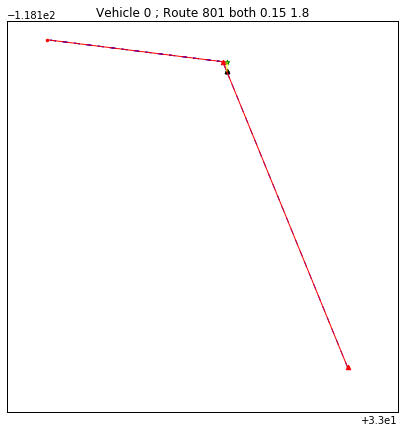

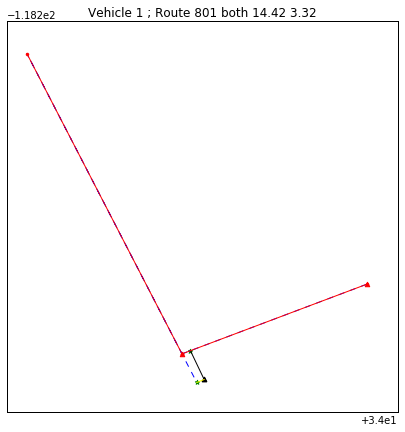

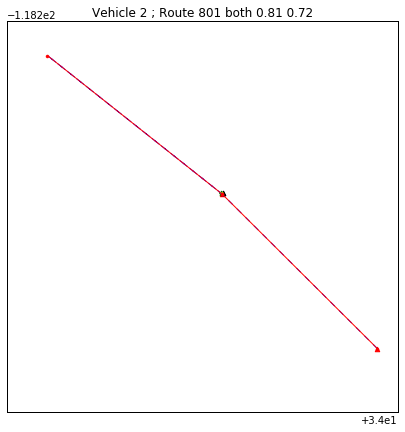

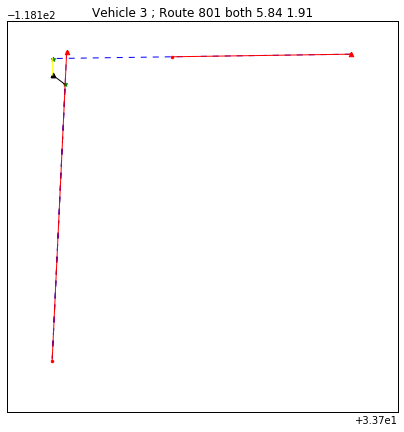

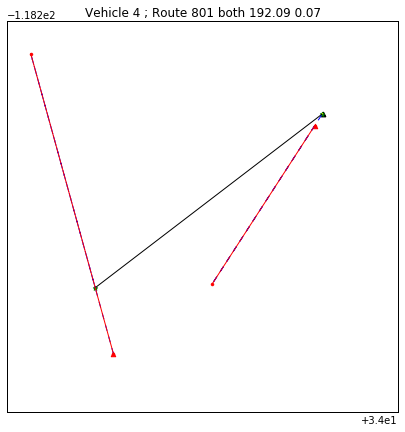

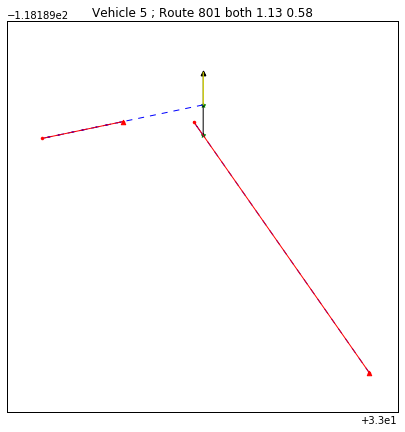

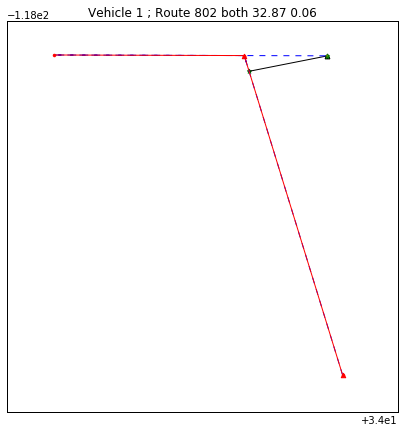

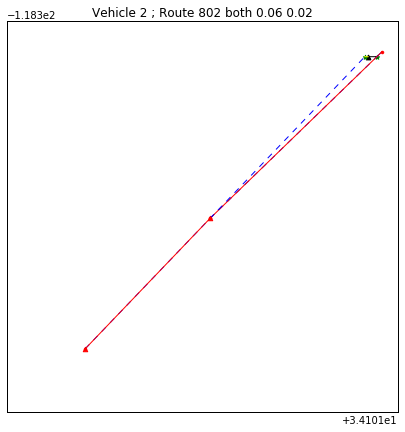

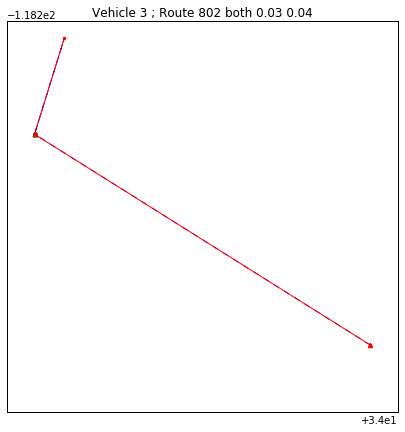

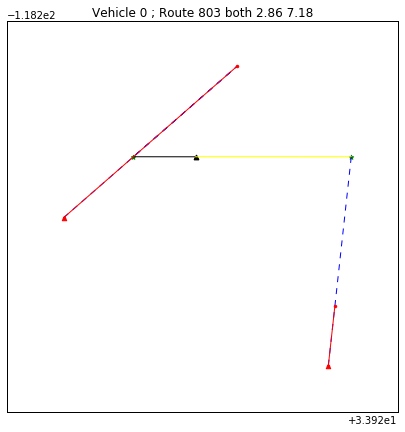

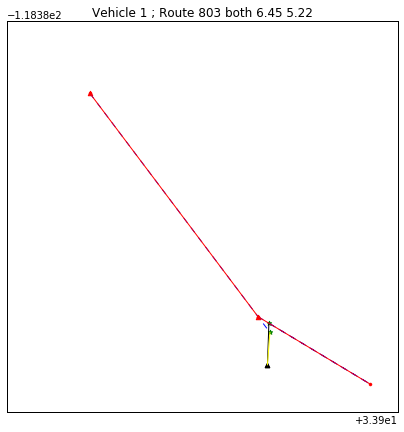

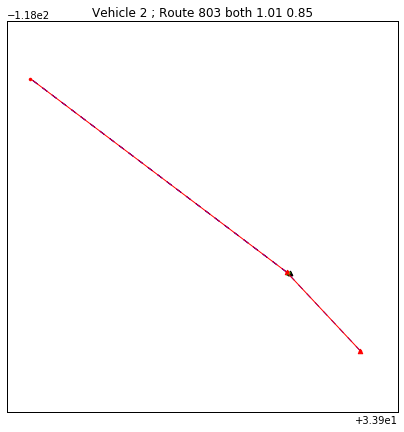

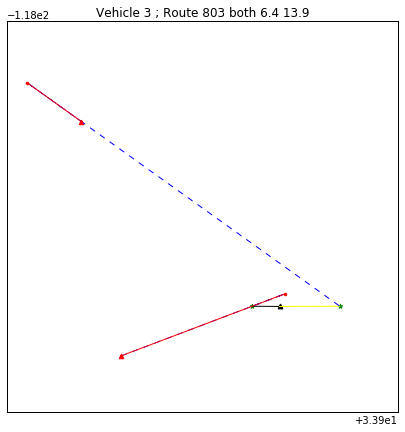

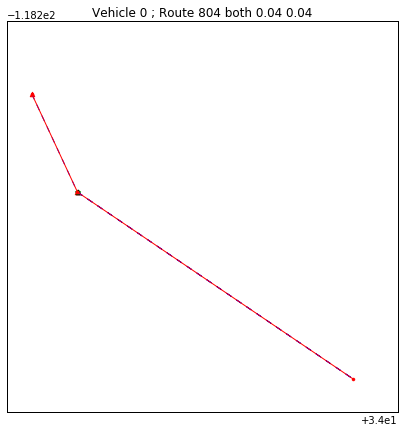

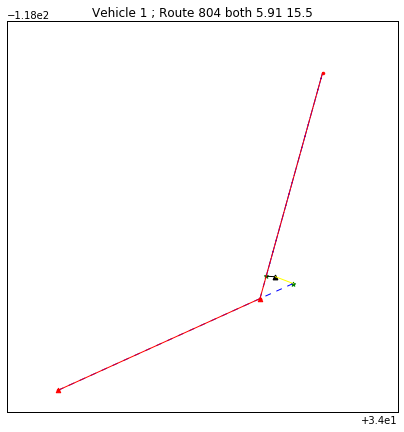

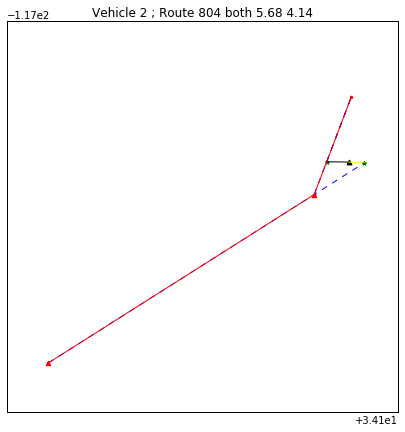

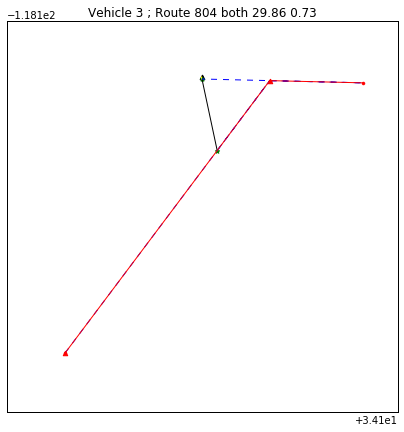

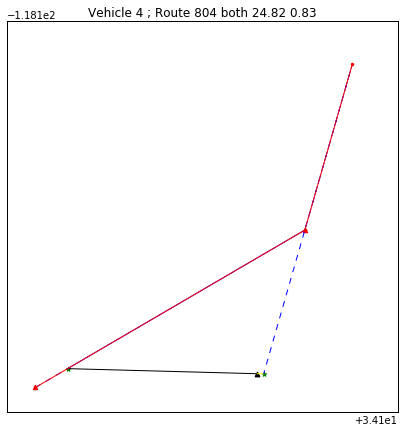

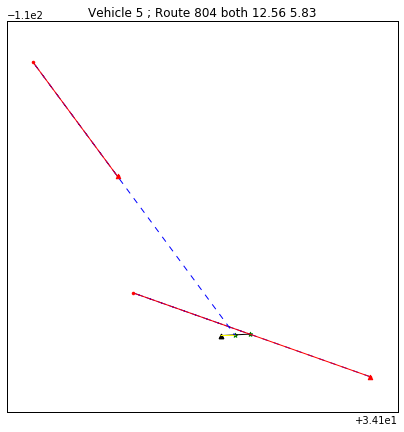

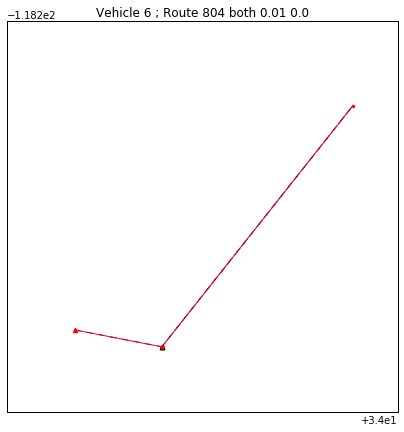

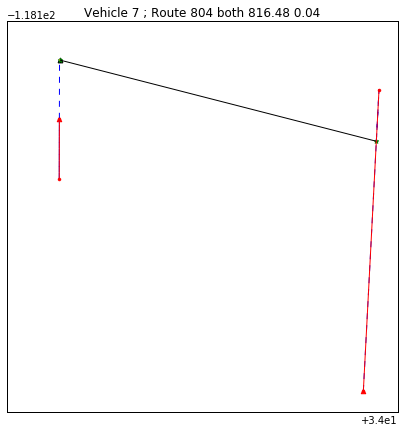

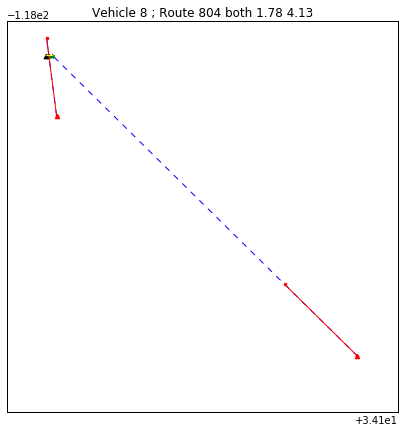

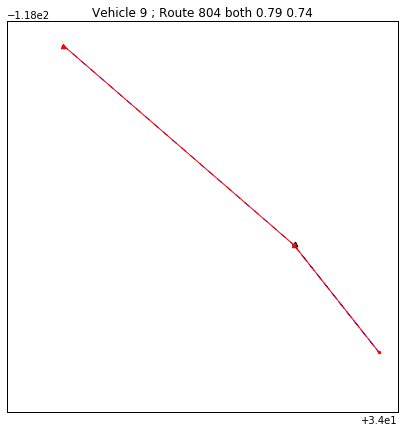

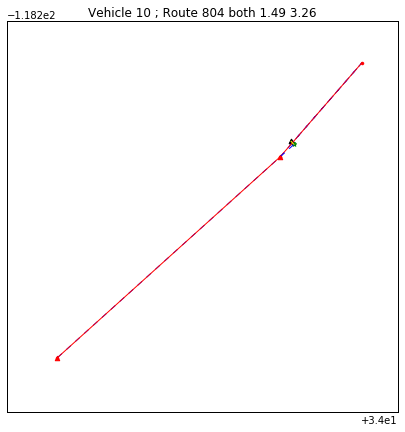

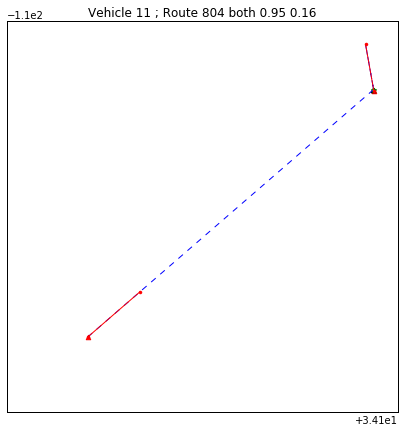

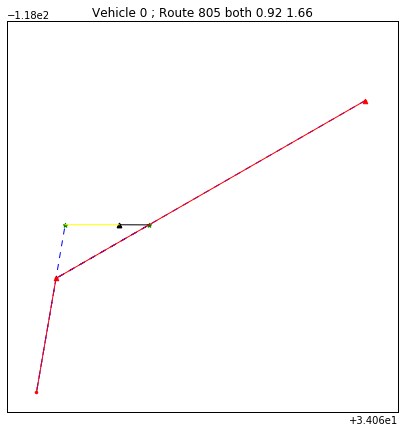

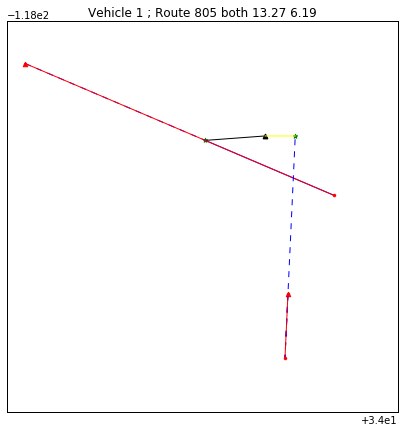

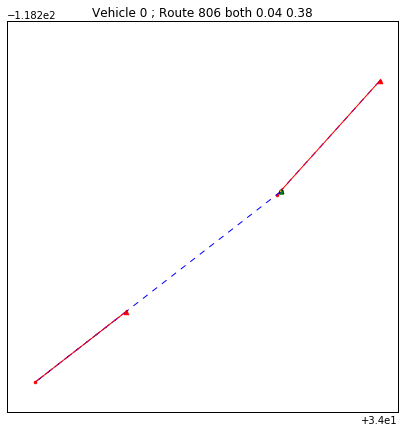

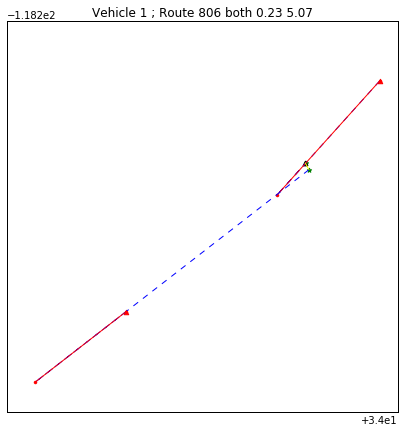

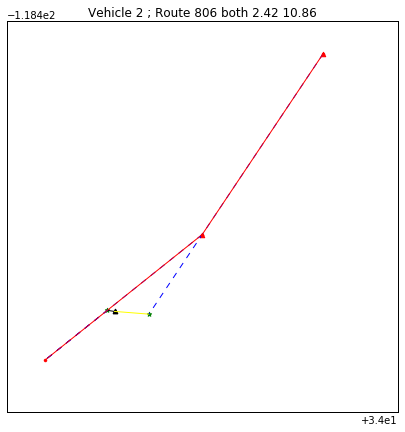

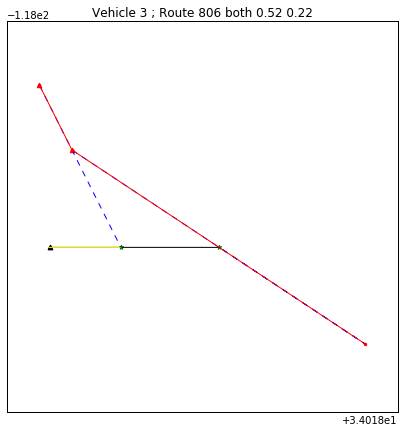

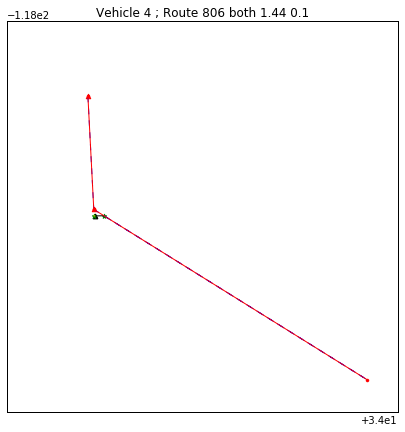

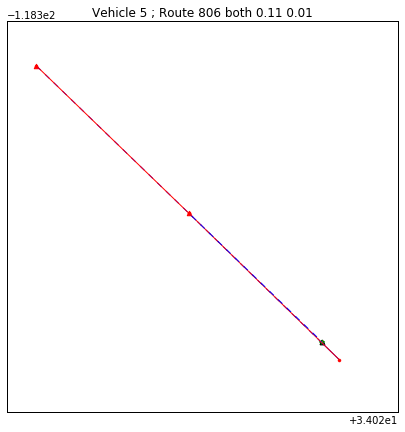

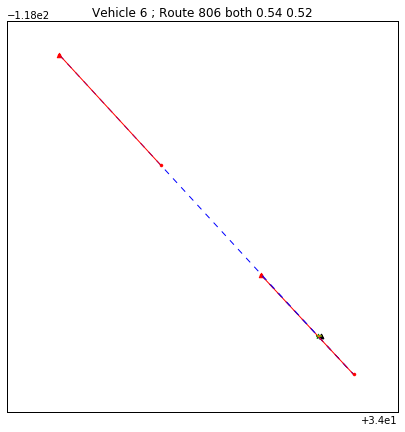

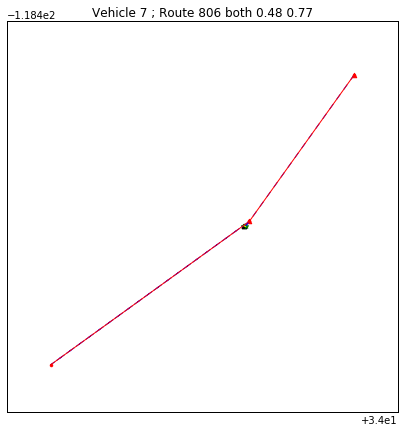

In [51]:
#Analyzing when not_in_between distance < in_between distance
for route in stop_coordinates_and_distances:
    no_of_stops = stop_coordinates_and_distances[route]['no_of_stops']
    stop_coordinates = stop_coordinates_and_distances[route]['stop_coordinates']
    stop_distances = stop_coordinates_and_distances[route]['stop_distances']
    vehicle_coordinates = route_wise_current_vehicles[route]['vehicle_coordinates']
    distance = stop_distances
    for pos, vehicle_coordinate in enumerate(vehicle_coordinates):
        output_in_between, output_not_in_between = find_adjacent_stations(vehicle_coordinate, stop_coordinates, stop_distances, no_of_stops)
        #pprint.pprint(output_in_between)
        #print()
        #pprint.pprint(output_not_in_between)
        #print("******************")
        title = f"Vehicle {pos} ; Route {route}"
        if output_in_between and output_not_in_between: 
            output_in_between[1]
            title += f" both {round(output_in_between[1]*10000,2)} {round(output_not_in_between[1]*10000,2)}"
            output = list(zip(output_in_between, output_not_in_between))
            starts = []
            ends = []
            for i in output[0]:
                starts.append(stop_coordinates[i])
                ends.append(stop_coordinates[i+1])
            plot_stations(vehicle_coordinate, output[2], starts, ends, title, output[-1])

# Summary

After visual inspection, it seems like the __arg-min (projection of the vehicle position onto the linesegments joining the train stations lying *on* the linesegment)__ works pretty well in finding where along the track, the vehicle is currently. Any vehicle for which there are *no* linesegments on which its projection lies, seems to be almost at a station. This station can be found by the __argmin(projection of the vehicle position onto the linesegments joining the train stations lying *not on* the linesegment)__
